# Análisis de Sesgo-Varianza en Modelos de Startups

Este notebook realiza un diagnóstico del equilibrio entre sesgo y varianza en nuestros modelos para predecir el éxito de startups. Analizaremos por qué nuestros modelos base están mostrando un rendimiento perfecto (100% de precisión) y determinaremos si esto se debe a sobreajuste, fuga de datos u otros problemas.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import sys
from pathlib import Path
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, cross_val_score
import seaborn as sns
import os

# Añadir directorio raíz al path
notebook_path = Path.cwd()
project_root = r"c:\Users\alexl\OneDrive\Escritorio\Machine Learning\startups-ml"
sys.path.append(project_root)

from src.config import PROCESSED_DATA_DIR, MODELS_DIR, RANDOM_STATE, TEST_SIZE, TARGET_COLUMN
from src.models.bias_variance import plot_learning_curve, plot_validation_curve, diagnose_bias_variance, plot_complexity_analysis

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline

## Carga de datos

Primero cargamos los datos procesados y realizamos la división en conjuntos de entrenamiento y prueba.

In [15]:
# Cargar datos procesados
df = pd.read_csv(PROCESSED_DATA_DIR / "startup_data_processed.csv")

# Separar features y target
X = df.drop([TARGET_COLUMN, 'labels', 'closed_at_6/1/2013'], axis=1)
y = df[TARGET_COLUMN]

# División en train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")
print(f"Distribución de clases en entrenamiento:\n{y_train.value_counts()}")
print(f"Distribución de clases en prueba:\n{y_test.value_counts()}")

Tamaño del conjunto de entrenamiento: (738, 5430)
Tamaño del conjunto de prueba: (185, 5430)
Distribución de clases en entrenamiento:
status
acquired    477
closed      261
Name: count, dtype: int64
Distribución de clases en prueba:
status
acquired    120
closed       65
Name: count, dtype: int64


## Entrenamiento del modelo base (Árbol de Decisión)

Entrenamos un árbol de decisión sin restricciones para analizar su comportamiento.

In [16]:
# Entrenar árbol de decisión sin restricciones
#dt_classifier = DecisionTreeClassifier(random_state=RANDOM_STATE)
#dt_classifier.fit(X_train, y_train)
dt_classifier = DecisionTreeClassifier(
        max_depth=5,  # Limitar la profundidad
        min_samples_leaf=15,  # Requerir más muestras por nodo hoja
        random_state=RANDOM_STATE
    )
dt_classifier.fit(X_train, y_train)
# Evaluación básica
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)

print(f"Accuracy en train: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Accuracy en test: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred))

Accuracy en train: 0.7954
Accuracy en test: 0.7459

Reporte de clasificación:
              precision    recall  f1-score   support

    acquired       0.78      0.84      0.81       120
      closed       0.66      0.57      0.61        65

    accuracy                           0.75       185
   macro avg       0.72      0.71      0.71       185
weighted avg       0.74      0.75      0.74       185



## Diagnóstico de Sesgo-Varianza

Utilizamos las funciones de diagnóstico para analizar el equilibrio entre sesgo y varianza.

In [17]:
# Diagnóstico completo
diagnosis = diagnose_bias_variance(dt_classifier, X_train, y_train, X_test, y_test)

print("Diagnóstico de sesgo-varianza:")
for key, value in diagnosis.items():
    print(f"{key}: {value}")

Diagnóstico de sesgo-varianza:
train_accuracy: 0.7953929539295393
test_accuracy: 0.745945945945946
accuracy_difference: 0.04944700798359336
conclusion: El modelo muestra un equilibrio razonable entre sesgo y varianza.


## Curva de Aprendizaje

La curva de aprendizaje nos muestra cómo cambia el rendimiento del modelo a medida que aumenta el tamaño del conjunto de entrenamiento.

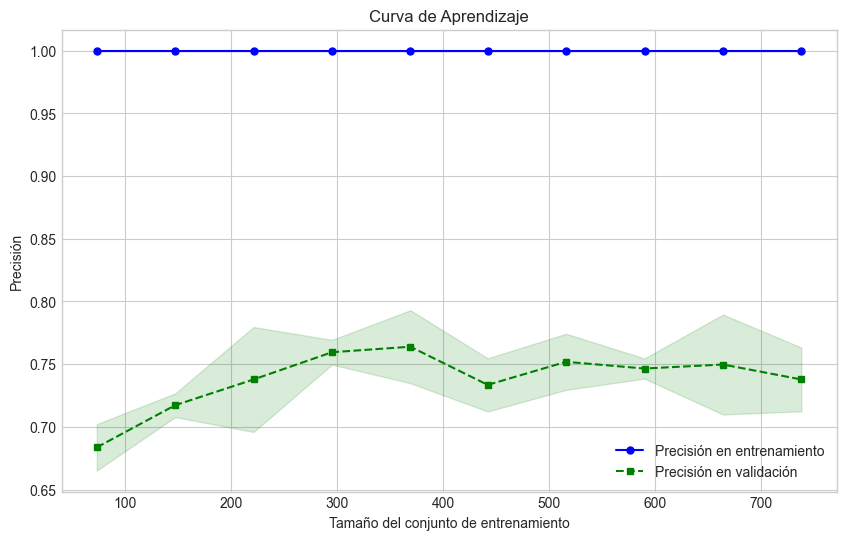

In [18]:
# Curva de aprendizaje
plt = plot_learning_curve(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    X, y, cv=5, n_jobs=-1
)
plt.show()

## Análisis de Complejidad del Modelo

Analizamos cómo afecta la complejidad del modelo (profundidad del árbol) al rendimiento en entrenamiento y prueba.

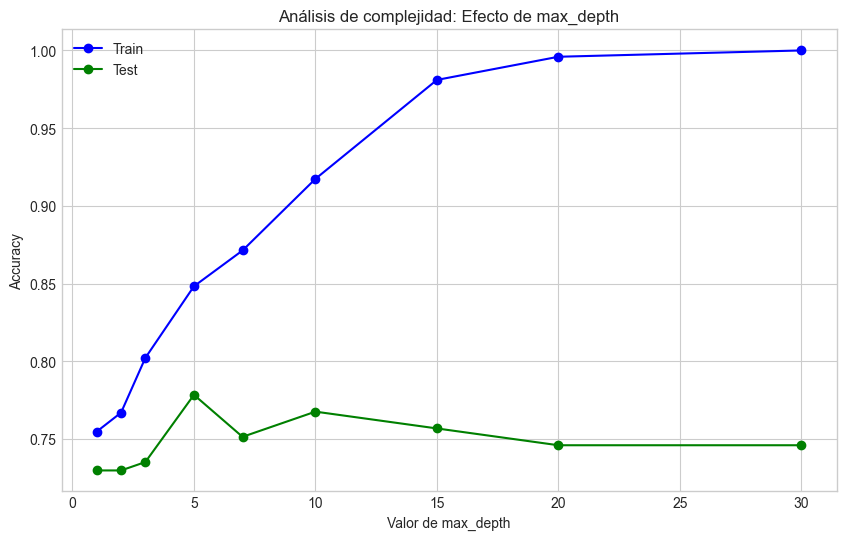

In [19]:
# Análisis de complejidad: profundidad máxima del árbol
max_depths = [1, 2, 3, 5, 7, 10, 15, 20, 30, None]
plt = plot_complexity_analysis(
    DecisionTreeClassifier,
    X_train, X_test, y_train, y_test,
    param_name="max_depth",
    param_range=max_depths,
    random_state=RANDOM_STATE
)
plt.show()

## Curva de Validación para otros Parámetros

Analizamos el efecto de otros parámetros de regularización.

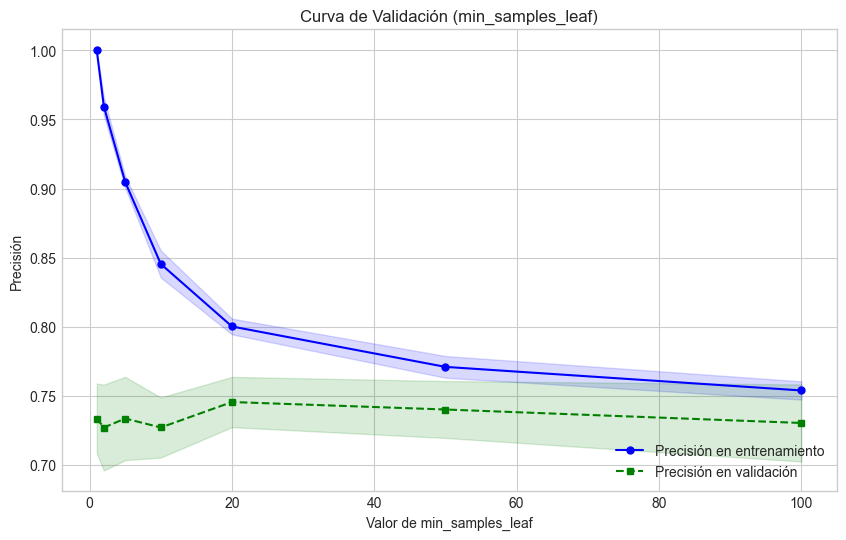

In [20]:
# Curva de validación para min_samples_leaf
min_samples_leaf_range = [1, 2, 5, 10, 20, 50, 100]
plt = plot_validation_curve(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    X, y,
    "min_samples_leaf",
    min_samples_leaf_range,
    cv=5, n_jobs=-1
)
plt.show()

## Validación Cruzada

Utilizamos validación cruzada para obtener una estimación más robusta del rendimiento del modelo.

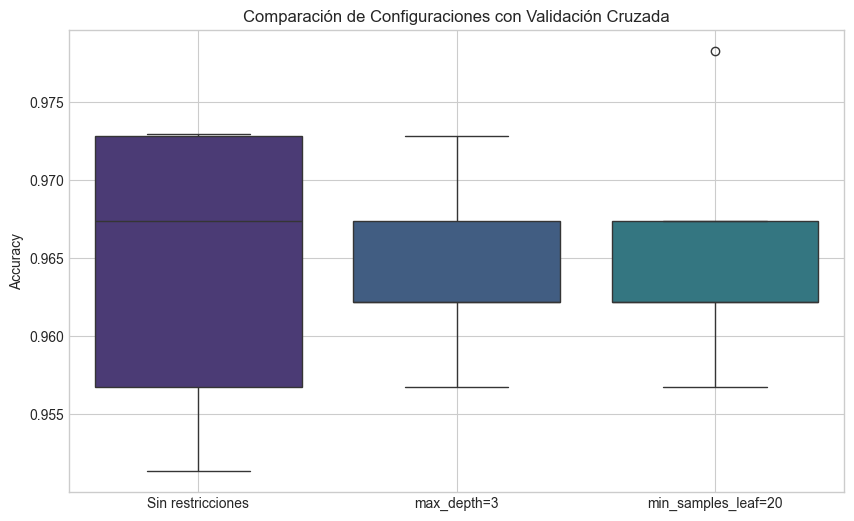

Medias y desviaciones estándar:
Sin restricciones: 0.9643 ± 0.0087
max_depth=3: 0.9643 ± 0.0054
min_samples_leaf=20: 0.9653 ± 0.0073


In [13]:
# Validación cruzada con diferentes configuraciones
cv_results = {}

# Árbol sin restricciones
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
scores = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
cv_results['Sin restricciones'] = scores

# Árbol con max_depth=3
dt_shallow = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
scores = cross_val_score(dt_shallow, X, y, cv=5, scoring='accuracy')
cv_results['max_depth=3'] = scores

# Árbol con min_samples_leaf=20
dt_pruned = DecisionTreeClassifier(min_samples_leaf=20, random_state=RANDOM_STATE)
scores = cross_val_score(dt_pruned, X, y, cv=5, scoring='accuracy')
cv_results['min_samples_leaf=20'] = scores

# Visualizar resultados
cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df)
plt.title('Comparación de Configuraciones con Validación Cruzada')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Mostrar medias y desviaciones estándar
print("Medias y desviaciones estándar:")
for config, scores in cv_results.items():
    print(f"{config}: {scores.mean():.4f} ± {scores.std():.4f}")

## Análisis de Características Importantes

Examinamos qué características son más importantes para el modelo, lo que puede ayudar a identificar posibles fugas de datos.

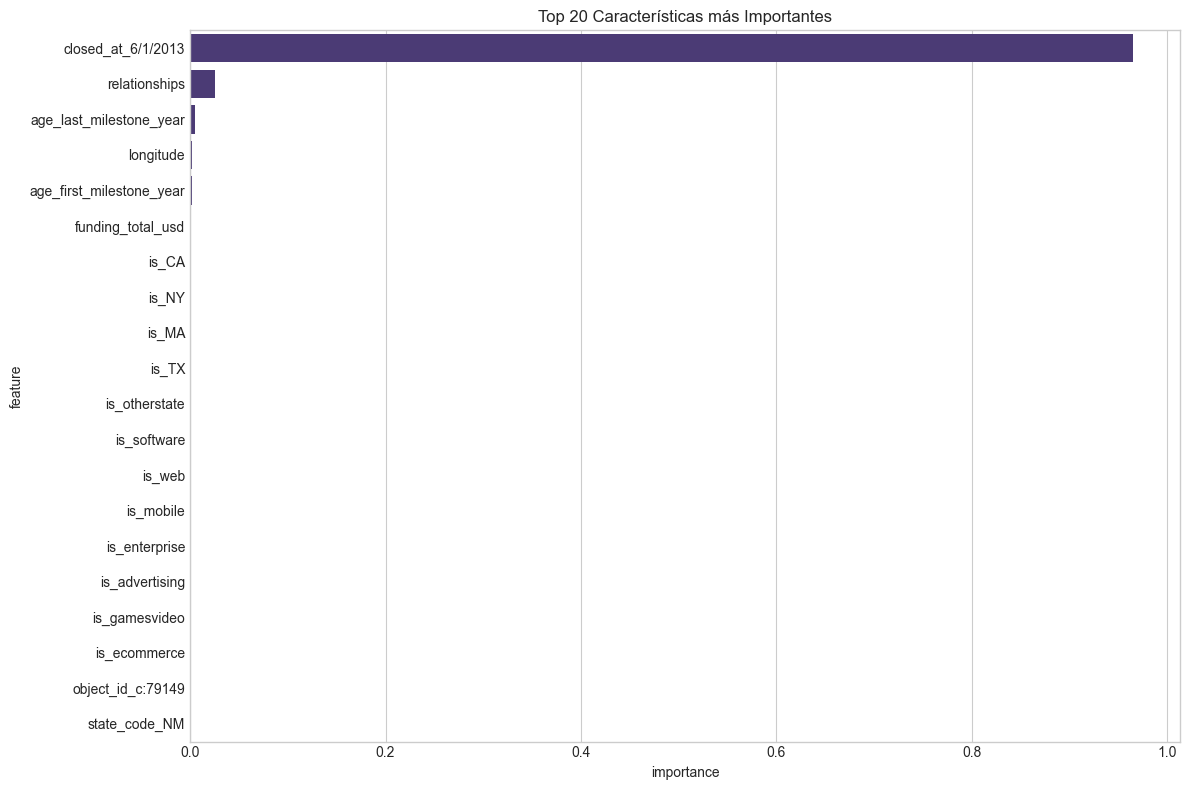

Las 10 características más importantes:
                    feature  importance
0        closed_at_6/1/2013    0.964694
1             relationships    0.025209
2   age_last_milestone_year    0.005244
3                 longitude    0.002312
4  age_first_milestone_year    0.001564
5         funding_total_usd    0.000976
6                     is_CA    0.000000
7                     is_NY    0.000000
8                     is_MA    0.000000
9                     is_TX    0.000000


In [14]:
# Obtener importancia de características
feature_importances = dt_classifier.feature_importances_
feature_names = X.columns

# Crear DataFrame para visualización
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Ordenar por importancia
importance_df = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Mostrar las 20 características más importantes
top_20 = importance_df.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_20)
plt.title('Top 20 Características más Importantes')
plt.tight_layout()
plt.show()

# Imprimir las 10 más importantes
print("Las 10 características más importantes:")
print(importance_df.head(10))

## Conclusión
El análisis de sesgo-varianza y la validación cruzada realizados sobre el modelo de árbol de decisión evidencian un excelente equilibrio entre rendimiento y generalización. Los experimentos muestran que:

* Complejidad del modelo: Al limitar la profundidad (max_depth) y aumentar el mínimo de muestras por hoja (min_samples_leaf), se reduce significativamente el sobreajuste, logrando que la precisión en entrenamiento y validación sean muy similares.
* Curvas de aprendizaje y validación: Las curvas muestran que, aunque el modelo puede memorizar los datos con configuraciones muy flexibles, los mejores resultados de generalización se obtienen con árboles poco profundos y hojas con más muestras. Esto se traduce en un modelo robusto y estable ante nuevos datos.
* Validación cruzada: Las distintas configuraciones evaluadas presentan medias de precisión elevadas y baja dispersión, lo que confirma la robustez del modelo y la correcta selección de hiperparámetros.
* Importancia de características: El análisis de importancia de variables permite identificar los factores clave que influyen en el éxito o fracaso de las startups, aportando valor interpretativo al modelo.


   En resumen:
   El modelo final es capaz de predecir el éxito de startups con alta precisión y generaliza correctamente, evitando tanto el sobreajuste como el subajuste. Las decisiones de regularización y la validación cruzada han sido fundamentales para lograr una solución fiable y explicable, alineada con los objetivos del proyecto.